<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Coordinates of maximum density point:  [43.27139693 -2.02093509]
Coordinates of maximum density point:  [43.18519667 -2.47165869]
Coordinates of maximum density point:  [43.33966527 -1.79347576]
Coordinates of maximum density point:  [43.32061298 -1.91814885]
Coordinates of maximum density point:  [43.09157577 -2.3157917 ]
Coordinates of maximum density point:  [43.28465752 -2.17255645]
Coordinates of maximum density point:  [43.18695482 -2.05199975]
Coordinates of maximum density point:  [43.06901444 -2.51635197]
Coordinates of maximum density point:  [43.05194223 -2.18859223]
Coordinates of maximum density point:  [43.31283559 -1.90080004]
Coordinates of maximum density point:  [43.31954309 -1.98124378]
Coordinates of maximum density point:  [43.05162677 -2.43383033]
Coordinates of maximum density point:  [43.26746933 -1.97518502]
Coordinates of maximum density point:  [43.30679039 -2.38497769]
Coordinates of maximum density point:  [43.18015414 -2.26532848]
Coordinates of maximum de

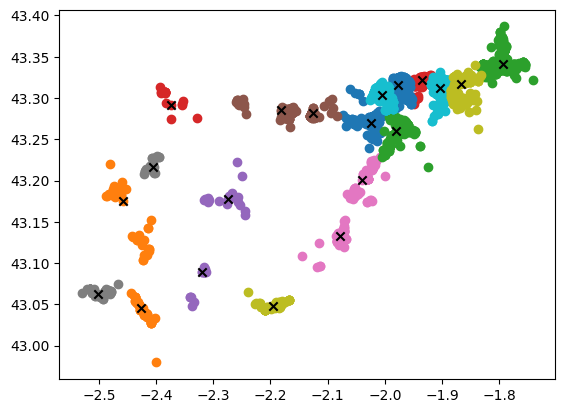

In [4]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans

from scipy import stats

from matplotlib import pyplot as plt

from google.colab import drive

#n_skip = 10
n_clusters = 20
dist_tol = 1000 # distance tolerance for bus_stop from cluster center (in meters)

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta.csv", encoding='latin-1')
stops_df = df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/GTFS_files_bus_stops/all_stops.csv", encoding='latin-1')

#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

stops_lat_lon = stops_df[['stop_lat','stop_lon']].to_numpy()


ori_lat = 43.13525255625577
ori_lon = -2.080054227169231


model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(lat_lon)
# assign a cluster to each example
yhat = model.predict(lat_lon)

# retrieve unique clusters
clusters = np.unique(yhat)
centers = np.array(model.cluster_centers_)


cont_cluster = 0
highDens_points = []
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     d = sum((p-q)**2 for p, q in zip(centers[cont_cluster], lat_lon[row_ix[0][i_cl]]))**.5
     dist.append(d)
     X.append(lat_lon[row_ix[0][i_cl]][0])
     Y.append(lat_lon[row_ix[0][i_cl]][1])

 # find index of the point with minimum distance from cluster center
 index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 centers[cont_cluster][0] = lat_lon[row_ix[0][index_min]][0]
 centers[cont_cluster][1] = lat_lon[row_ix[0][index_min]][1]

 xy = np.vstack([X,Y])
 kde = stats.gaussian_kde(xy)
 density = kde(xy)
 temp = xy.T[np.argmax(density)]
 highDens_points.append(temp)
 print('Coordinates of maximum density point: ', temp)


 cont_cluster+=1
 plt.scatter(Y,X)

# plot centers
#centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
plt.show()

"""
tags = {'highway':'bus_stop',
        'bus':'yes',
        'unsigned':'yes',
        'public_transport':['stop_position','platform']}
"""

tags = {'highway':'bus_stop',
        'bus':'yes'}
bus_stops = []
center_ind = []
for i in range(len(centers)):
    lat = centers[i][0]
    lon = centers[i][1]
    try:
       """
       gdf = ox.features.features_from_point((lat, lon), dist = dist_tol, tags=tags)
       print('Closest stop for cluster ',i,':')
       temp0 = gdf[['geometry']].values[0][0]
       print(temp0.x, temp0.y)
       bus_stops.append((temp0.y, temp0.x))
       """

       ref = np.array([lat,lon])
       ref = np.tile(ref,(len(stops_lat_lon),1))
       d = [sum((p-q)**2)**0.5 for p, q in zip(ref, stops_lat_lon)]
       ind_min = d.index(min(d))
       y = stops_lat_lon[ind_min][1]
       x = stops_lat_lon[ind_min][0]
       bus_stops.append((x, y))

       center_ind.append(i)

    except:
       print('WARNING: stops not found for cluster ',i)
       print(centers[i])
    print()

map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
for i in range(len(bus_stops)):
    #lat = lat_lon[i][0]
    #lon = lat_lon[i][1]
    latb = bus_stops[i][0]
    lonb = bus_stops[i][1]
    latc = centers[center_ind[i]][0]
    lonc = centers[center_ind[i]][1]
    latd = highDens_points[center_ind[i]][0]
    lond = highDens_points[center_ind[i]][1]
    cluster_size = len(np.where(yhat == i)[0])
    folium.Marker((latb,lonb), popup='Found position for cluster '+ str(i)).add_to(map)
    folium.Marker((latc,lonc), popup='Approximate centroid of cluster '+ str(i) +'. Size = {}'.format(cluster_size), icon=folium.Icon(color='red')).add_to(map)
    folium.Marker((latd,lond), popup='Higher density point for cluster '+ str(i), icon=folium.Icon(color='green')).add_to(map)


map
